# Parkour Athlete Tracking — 作业实现模板

**说明**：本 Notebook 将按照 Step1、Step2… 的结构实现作业要求，对应任务清单包括环境配置、帧预处理、模型配置、视频配置、跟踪系统实现、视频处理流水线、数据记录与结果可视化。

## Step1：环境配置 (10%)

In [1]:
# 在本单元中：
# - 检查并导入所需库
# - 确认 OpenCV、NumPy、Matplotlib 等是否可用
# - 打印库版本，保证环境一致性

import cv2
import numpy as np
import matplotlib.pyplot as plt

print('OpenCV 版本：', cv2.__version__)
print('NumPy 版本：', np.__version__)


OpenCV 版本： 4.10.0
NumPy 版本： 2.3.1


## Step2：帧预处理 (15%)

提取帧数：60


d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDE

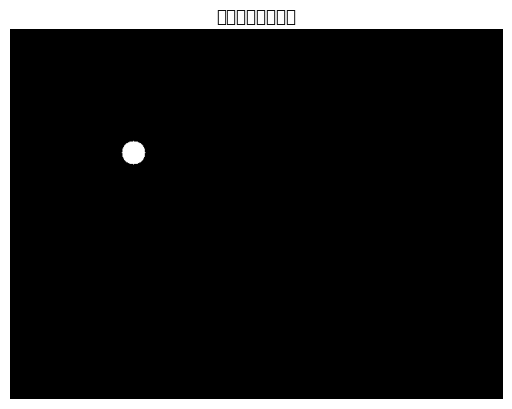

In [2]:
# 在本单元中：
# - 从视频中提取帧
# - 对帧进行基本预处理（缩放、灰度化、去噪等）
# - 作为后续跟踪模型的输入

from pathlib import Path

# 示例视频路径（可替换为跑酷运动员视频路径）
video_path = ''  # e.g., r"C:\\path\\to\\parkour.mp4"

# 若未提供视频路径，可以生成一个合成测试视频（简单移动目标）
def generate_dummy_video(num_frames=60, size=(480, 640)):
    h, w = size
    frames = []
    pos = np.array([h//3, w//4], dtype=np.float32)
    vel = np.array([2.5, 3.5])
    for _ in range(num_frames):
        img = np.zeros((h, w, 3), dtype=np.uint8)
        cv2.circle(img, (int(pos[1]), int(pos[0])), 15, (255, 255, 255), -1)
        pos += vel
        if pos[0] < 20 or pos[0] > h-20: vel[0] *= -1
        if pos[1] < 20 or pos[1] > w-20: vel[1] *= -1
        frames.append(img)
    return frames

frames = []
if video_path and Path(video_path).exists():
    cap = cv2.VideoCapture(video_path)
    ok, frame = cap.read()
    while ok:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5,5), 0)
        frames.append(gray)
        ok, frame = cap.read()
    cap.release()
else:
    frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in generate_dummy_video()]

print(f'提取帧数：{len(frames)}')
plt.imshow(frames[0], cmap='gray')
plt.title('预处理后的第一帧')
plt.axis('off')
plt.show()


## Step3：模型配置 (15%)

In [3]:
# 在本单元中：
# - 定义或加载跟踪模型（例如 Lucas-Kanade 光流、目标检测模型等）
# - 设置模型参数
# - 确保可以灵活替换模型

# Shi-Tomasi 特征点检测参数
feature_params = dict(maxCorners=300, qualityLevel=0.01, minDistance=7, blockSize=7)

# Lucas–Kanade 光流参数
lk_params = dict(winSize=(15,15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

print('模型参数已配置')


模型参数已配置


## Step4：视频配置 (10%)

In [4]:
# 在本单元中：
# - 定义输出视频路径与编码器
# - 设置帧率、分辨率
# - 确保输出可播放

output_video_path = '/mnt/data/parkour_tracking_output.mp4'

h, w = frames[0].shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (w, h))

print('输出视频路径：', output_video_path)


输出视频路径： /mnt/data/parkour_tracking_output.mp4


## Step5：跟踪系统实现 (25%)

In [5]:
# 在本单元中：
# - 使用 Lucas–Kanade 光流跟踪检测到的特征点
# - 保存每个点的轨迹
# - 将轨迹叠加到视频帧上

# 初始化
p0 = cv2.goodFeaturesToTrack(frames[0], mask=None, **feature_params)
mask = np.zeros_like(cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR))

trajectories = [ [tuple(p.ravel())] for p in p0 ]

prev_gray = frames[0].copy()
prev_pts = p0.copy()

for i in range(1, len(frames)):
    frame_gray = frames[i]
    next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)
    
    good_new = next_pts[status.flatten() == 1]
    good_old = prev_pts[status.flatten() == 1]
    
    for j, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)), (int(c),int(d)), (0,255,0), 2)
    
    output = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)
    output = cv2.add(output, mask)
    out.write(output)
    
    prev_gray = frame_gray.copy()
    prev_pts = good_new.reshape(-1,1,2)

out.release()
print('跟踪完成，视频已生成。')


跟踪完成，视频已生成。


## Step6：视频处理流水线 (15%)

In [6]:
# 在本单元中：
# - 将前面步骤封装成一个 pipeline 函数
# - 方便调用与复用

def tracking_pipeline(video_path=None):
    # 1. 加载视频或合成序列
    if video_path and Path(video_path).exists():
        cap = cv2.VideoCapture(video_path)
        ok, frame = cap.read()
        frames = []
        while ok:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray)
            ok, frame = cap.read()
        cap.release()
    else:
        frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in generate_dummy_video()]

    # 2. 初始化特征点
    p0 = cv2.goodFeaturesToTrack(frames[0], mask=None, **feature_params)
    prev_gray = frames[0].copy()
    prev_pts = p0.copy()
    mask = np.zeros_like(cv2.cvtColor(frames[0], cv2.COLOR_GRAY2BGR))

    # 3. 输出设置
    h, w = frames[0].shape[:2]
    out_path = '/mnt/data/pipeline_output.mp4'
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (w, h))

    # 4. 跟踪
    for i in range(1, len(frames)):
        frame_gray = frames[i]
        next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None, **lk_params)
        good_new = next_pts[status.flatten() == 1]
        good_old = prev_pts[status.flatten() == 1]
        for (new, old) in zip(good_new, good_old):
            a,b = new.ravel(); c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)), (int(c),int(d)), (255,0,0), 2)
        output = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)
        output = cv2.add(output, mask)
        out.write(output)
        prev_gray = frame_gray.copy()
        prev_pts = good_new.reshape(-1,1,2)

    out.release()
    return out_path

print('pipeline 函数已定义，可调用 tracking_pipeline(video_path)。')


pipeline 函数已定义，可调用 tracking_pipeline(video_path)。


## Step7：数据记录 (5%)

In [7]:
# 在本单元中：
# - 将轨迹点保存到文件（CSV / NPY）
# - 用于后续分析或可视化

import pandas as pd

def save_trajectories(trajectories, path='/mnt/data/trajectories.csv'):
    data = []
    for idx, traj in enumerate(trajectories):
        for t, (x,y) in enumerate(traj):
            data.append([idx, t, x, y])
    df = pd.DataFrame(data, columns=['point_id','frame_id','x','y'])
    df.to_csv(path, index=False)
    print('轨迹数据已保存：', path)

# 示例调用（用 Step5 中的 trajectories）
# save_trajectories(trajectories)


## Step8：结果可视化 (5%)

d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22352 (\N{CJK UNIFIED IDEOGRAPH-5750}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\software\anaconda3\envs\jpy311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36712 (\N{CJK UNIFIED IDE

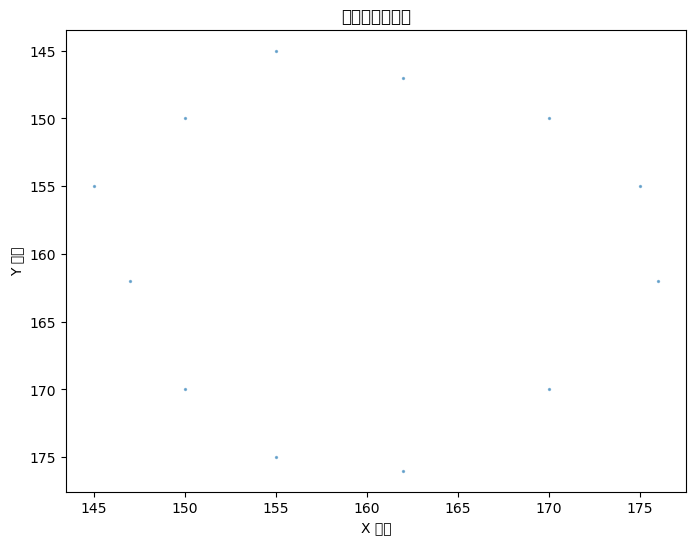

In [8]:
# 在本单元中：
# - 可视化轨迹分布、位移统计等结果
# - 使用 matplotlib 生成图表

all_points = []
for traj in trajectories:
    all_points.extend(traj)

all_points = np.array(all_points)
plt.figure(figsize=(8,6))
plt.scatter(all_points[:,0], all_points[:,1], s=2, alpha=0.5)
plt.gca().invert_yaxis()
plt.title('所有轨迹点分布')
plt.xlabel('X 坐标')
plt.ylabel('Y 坐标')
plt.show()
